<img heigth="8" src="https://i.imgur.com/DTmSLPg.png" alt="chartsper">

<h1 align="left">🎸 Chartsper 🎮</h1>

<p align="left"><i>Supervised Fine-Tuning (SFT) for Guitar Note Recognition</i></p>

<p align="left">
  Joseph Vergel | <a href="https://joefavergel.dev/">joefavergel.dev</a>
  <br>
  <b>Last updated:</b> <i>11/04/2024</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>
<p align="left">
  <a href="#introduction">Introduction</a><br>
  <a href="#1-data-adquisition">1. Data Adquisition</a><br>
  <a href="#2-exploratory-data-analysis">2. Exploratory Data Analysis</a><br>
  <br>
</p>

---

The `chartsper` exploratory notebook documents the application of Supervised Fine-Tuning (SFT) to a pre-trained deep learning model for guitar note recognition in rhythm games. It covers the selection of a model suitable for audio processing, details preprocessing techniques like spectral normalization and explores model retraining with hyperparameter tuning and domain-specific augmentations.

<a id="1-data-extraction"></a>
# Introduction

In [1]:
import os
import glob
import json
import pathlib

from IPython.display import Audio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pretty_midi
import librosa

In [2]:
try:
    import importlib

    __package__ = "chartsper"

    found = False
    while not found:
        os.chdir(os.path.join(os.getcwd(), os.pardir))
        found = bool(importlib.util.find_spec(__package__))
        if found:
            print(f"[INFO] WORKDIR: {os.path.join(os.getcwd(), os.pardir)}")
        continue
except ModuleNotFoundError as e:
    print("[ERROR] Verify WORKDIR execution: ", e)

[INFO] WORKDIR: /Users/joefaver/Codes/self/chartsper/..


In [3]:
import chartsper
from chartsper.graph import create_note_graph
from chartsper.io import load_instrument
from chartsper.logging import logger
from chartsper.plot import plot_graph, plot_spec
from chartsper.schemas import ChartSong, ChartFile, KIND_MAPPING

<a id="1-data-adquisition"></a>
# 1. Data Adquisition

To start, you can download some [chart pack](https://docs.google.com/spreadsheets/u/0/d/13B823ukxdVMocowo1s5XnT3tzciOfruhUVePENKc01o/htmlview?usp=drive_web&pli=1#) and put it in the `datalake/` directory.

In [4]:
DATASET = 'Guitar Hero World Tour'
DATAPATH = f'datalake/{DATASET}'
PROCESSED = f'datalake/{DATASET.replace(' ', '_').lower()}_processed/'
ALLOWED_EXTENSIONS = ['.mp3', '.ogg', '.mid', '.chart', '.ini']

if os.path.exists(DATAPATH):
    os.makedirs(PROCESSED, exist_ok=True)

In [5]:
titles = {
    path_.parent._str.split('/')[-1]: path_.parent
    for path in glob.glob(os.path.join(DATAPATH, '**/**'))
    if (path_ := pathlib.Path(path)) and path_.is_file() and path_.suffix in ['.ini']
}
chart_file_paths = {
    name: [
        path_ for path in glob.glob(os.path.join(path, '*'))
        if (path_ := pathlib.Path(path)) and path_.is_file() and path_.suffix.lower() in ALLOWED_EXTENSIONS]
    for name, path in titles.items()
}

In [6]:
artist_name = 'Eagles'
artist_clips = dict(filter(lambda item: item[0].startswith(artist_name), chart_file_paths.items()))
chart_name = list(artist_clips.keys())[0]
clip_path = artist_clips[chart_name][11]
clip_name = os.path.join(str(clip_path.parent).split('/')[-1], clip_path.name)

In [7]:
artist_name = 'Eagles'
chart_file_kinds = ['guitar', 'song', 'notes', 'preview']
allowed_extensions = ['.chart', '.mid', '.ogg']

char_path = dict(filter(lambda item: item[0].startswith(artist_name), titles.items()))
chart_name = list(char_path.keys())[0]
artist, title = tuple(chart_name.split(' - '))

for name, paths in dict(filter(lambda item: item[0].startswith(artist_name), chart_file_paths.items())).items():
    tmp = [path for path in paths if any(map(path.stem.startswith, chart_file_kinds)) and path.suffix.lower() in allowed_extensions]
    filtered = {
        file_kind: [
            ChartFile(**{
                'path': path,
                'file_type': {
                    'kind': KIND_MAPPING.get(file_kind) if file_kind != 'song' else KIND_MAPPING.get(file_kind).get(path.suffix),
                    'extension': path.suffix
                },
                'chart_type': file_kind
            })
            for path in tmp
            if path.stem.startswith(file_kind)
        ] for file_kind in chart_file_kinds}

chart_song = ChartSong(title=title, artist=artist, path=char_path[list(char_path.keys())[0]], **filtered)
y, sr = librosa.load(clip_path)
print(json.dumps(json.loads(chart_song.json()), indent=4))

{
    "title": "Hotel California",
    "artist": "Eagles",
    "path": "datalake/Guitar Hero World Tour/Eagles - Hotel California",
    "guitar": [
        {
            "path": "datalake/Guitar Hero World Tour/Eagles - Hotel California/guitar.ogg",
            "file_type": {
                "kind": "audio",
                "extension": ".ogg"
            },
            "chart_type": "guitar",
            "data": null
        }
    ],
    "song": [
        {
            "path": "datalake/Guitar Hero World Tour/Eagles - Hotel California/song.ogg",
            "file_type": {
                "kind": "audio",
                "extension": ".ogg"
            },
            "chart_type": "song",
            "data": null
        }
    ],
    "notes": [
        {
            "path": "datalake/Guitar Hero World Tour/Eagles - Hotel California/notes.mid",
            "file_type": {
                "kind": "notes",
                "extension": ".mid"
            },
            "chart_type": "notes"

In [8]:
instrument = load_instrument(chart_song.notes[0].path, 'PART GUITAR')
graph, node_color = create_note_graph(instrument, 96, 100)

y, sr = librosa.load(chart_song.guitar[0].path)
melspec = librosa.power_to_db(
    librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max
)

logger.info(f"Number of nodes: {graph.number_of_nodes()}")
logger.info(f"Number de edges: {graph.number_of_edges()}")

2024-04-21 11:43:24,851  [chartsper] [INFO]  Number of nodes: 16194
2024-04-21 11:43:24,865  [chartsper] [INFO]  Number de edges: 25574
2024-04-21 11:43:24,865  [chartsper] [INFO]  Number de edges: 25574


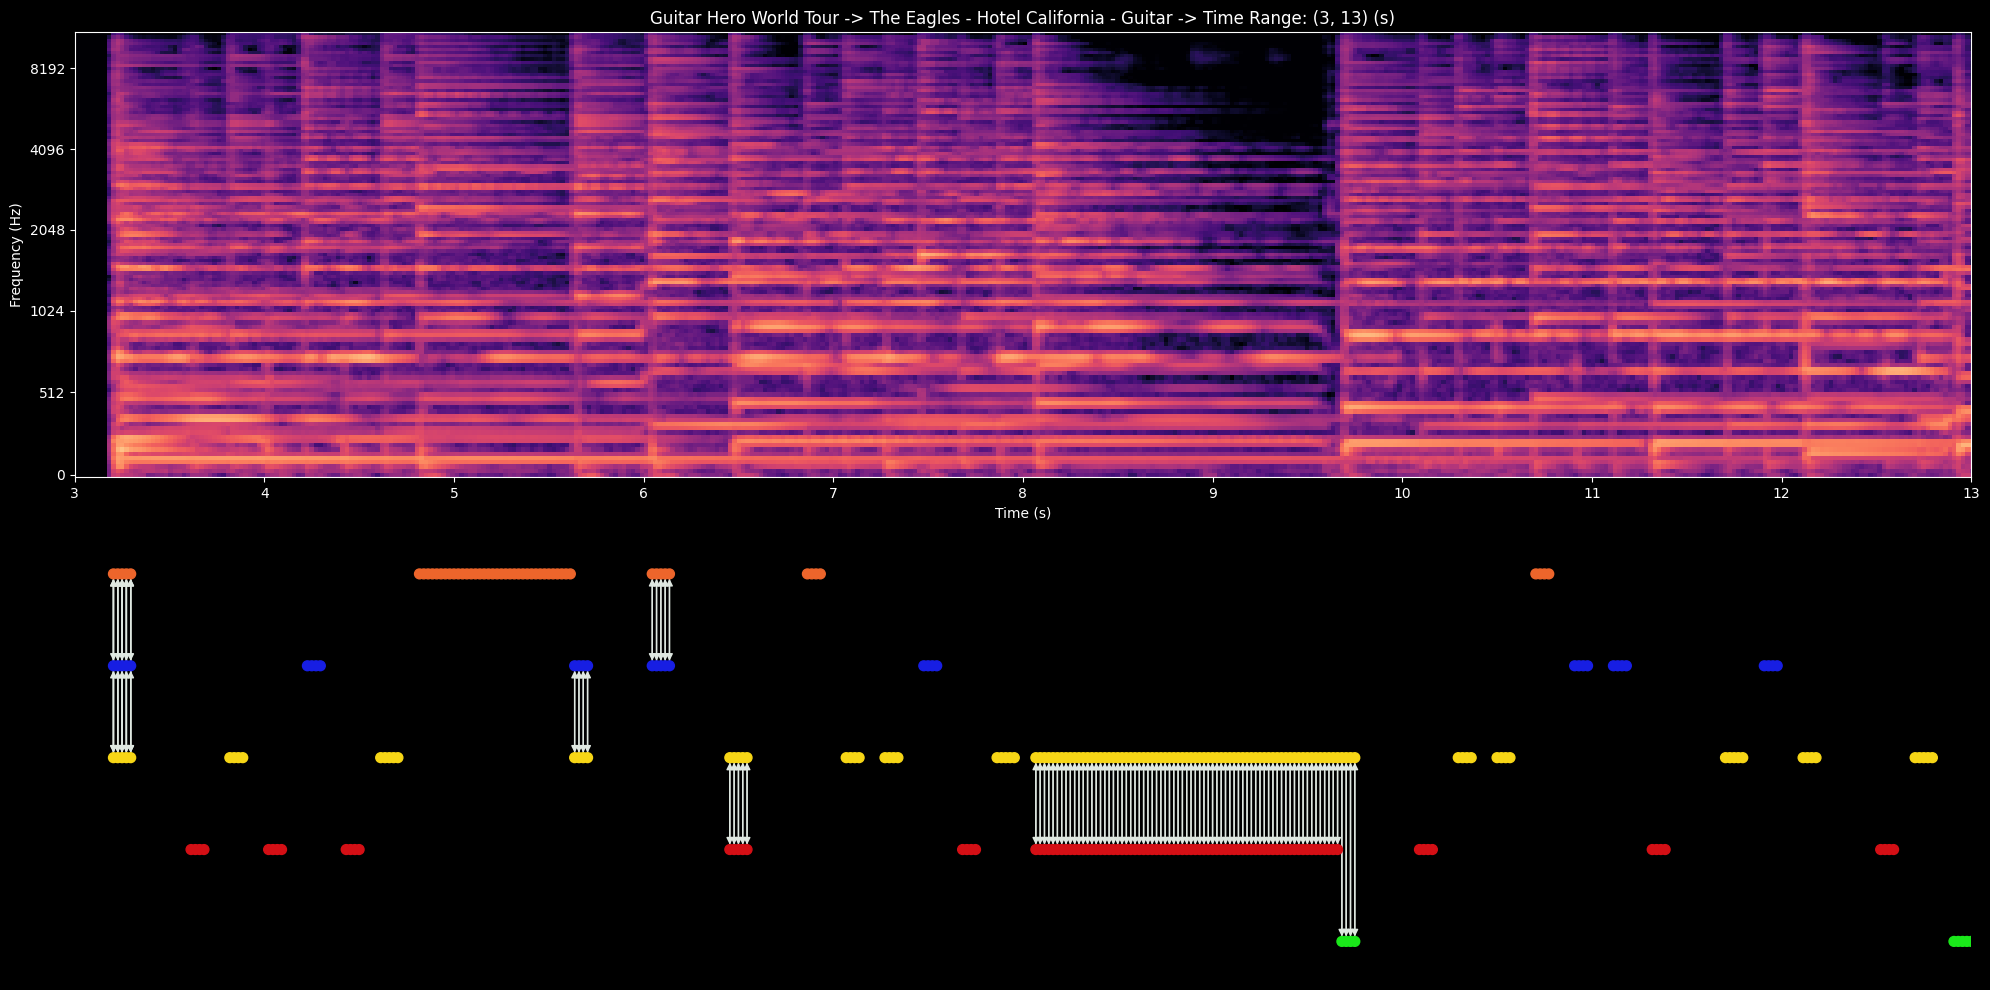

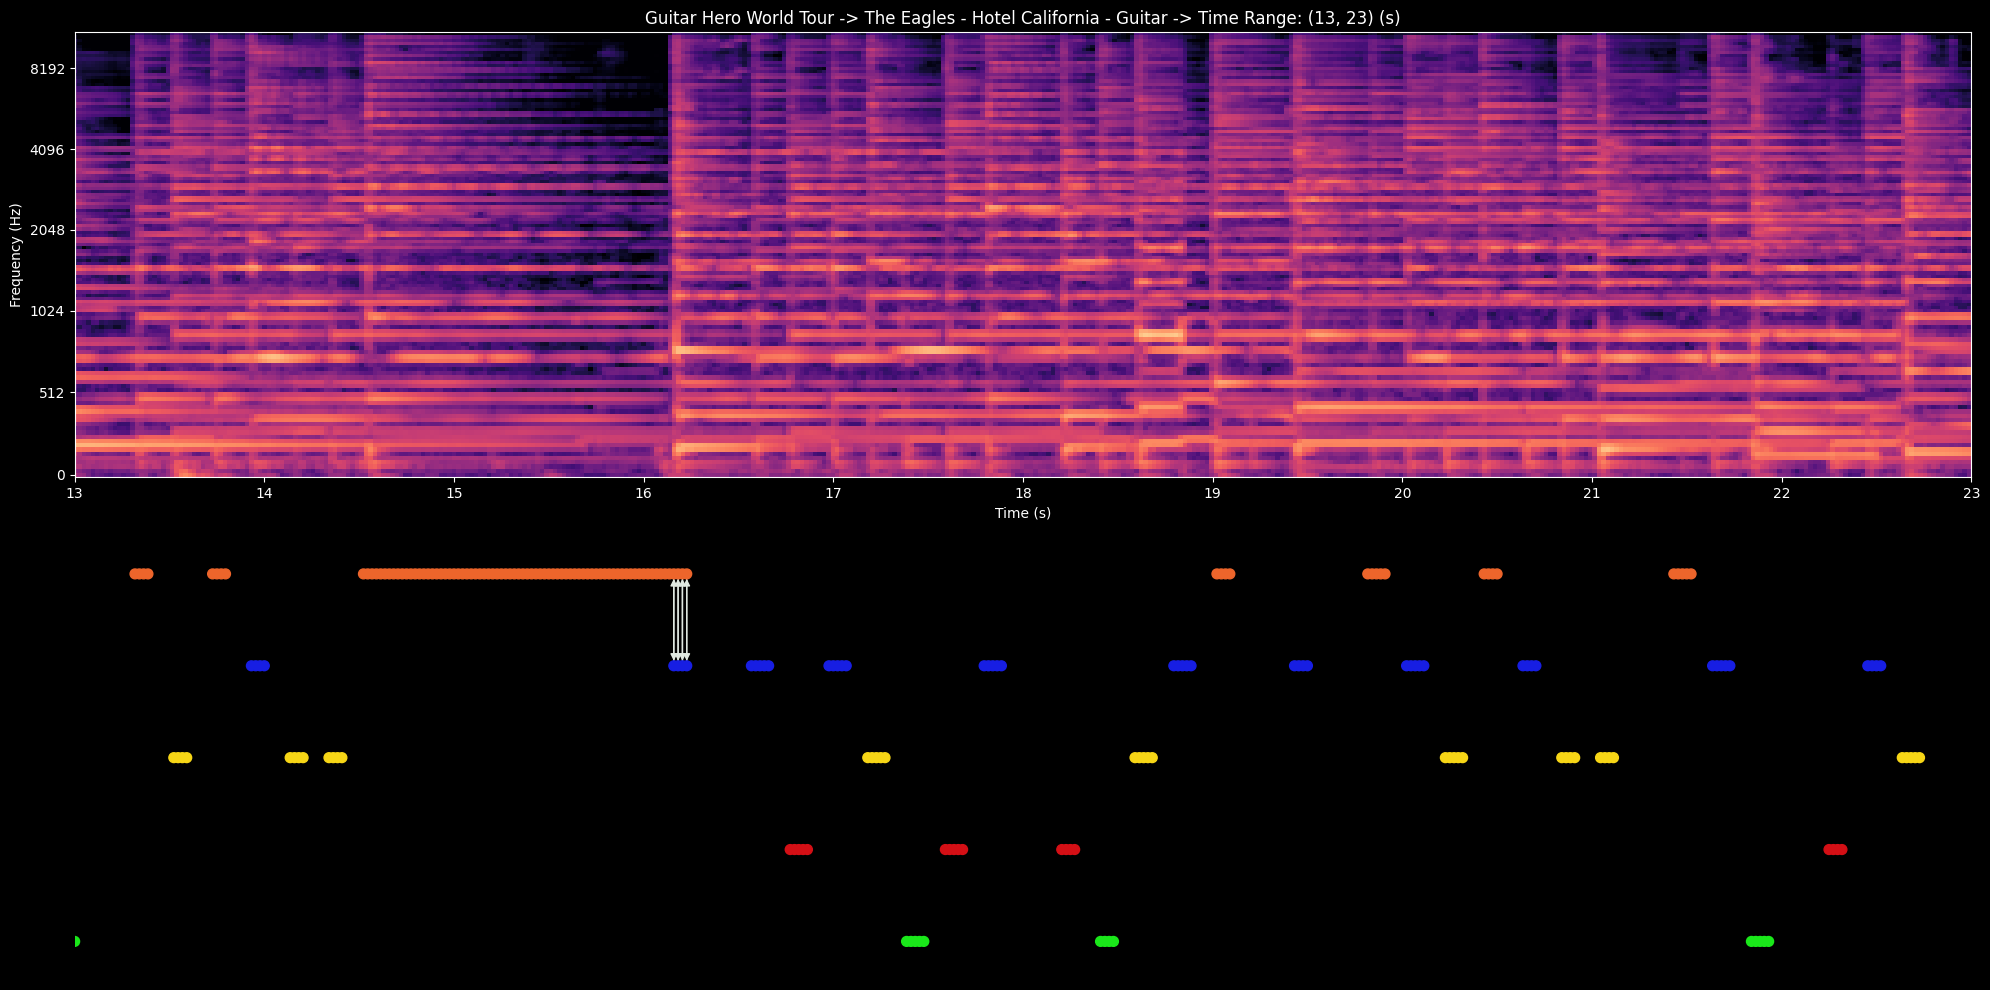

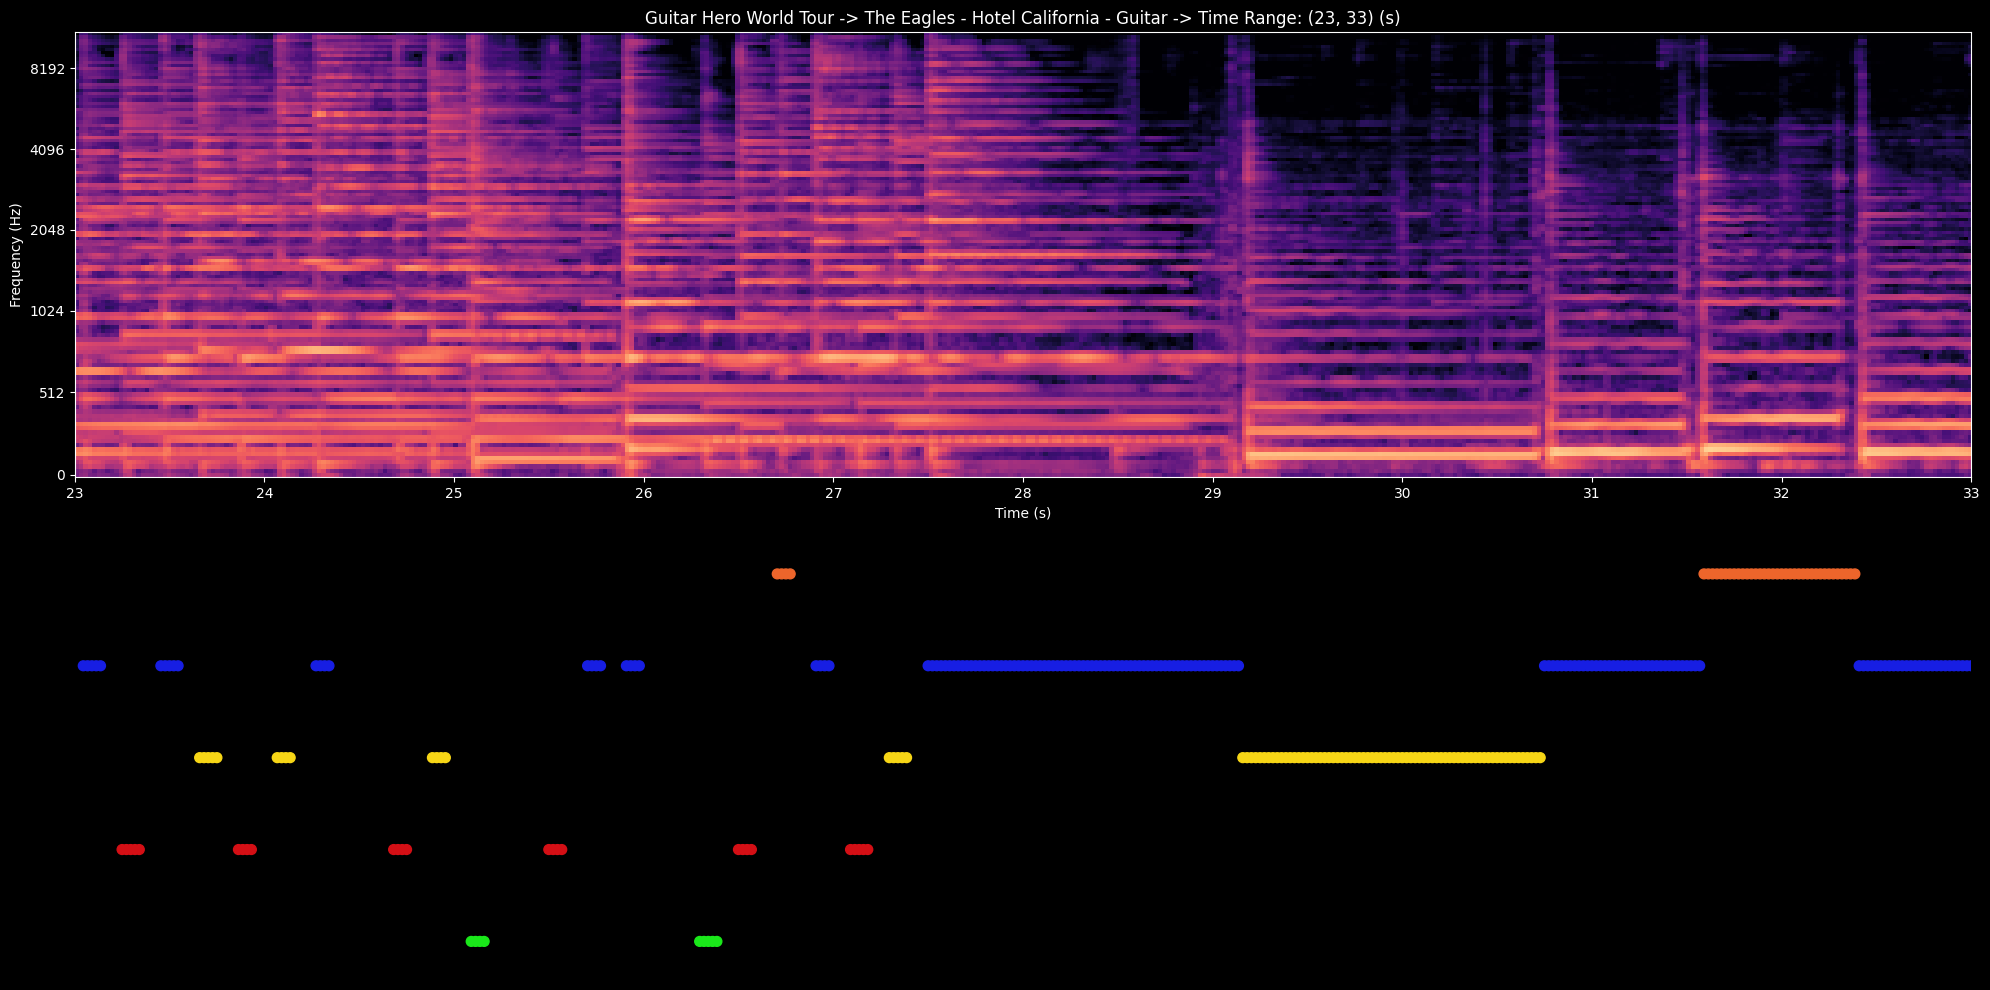

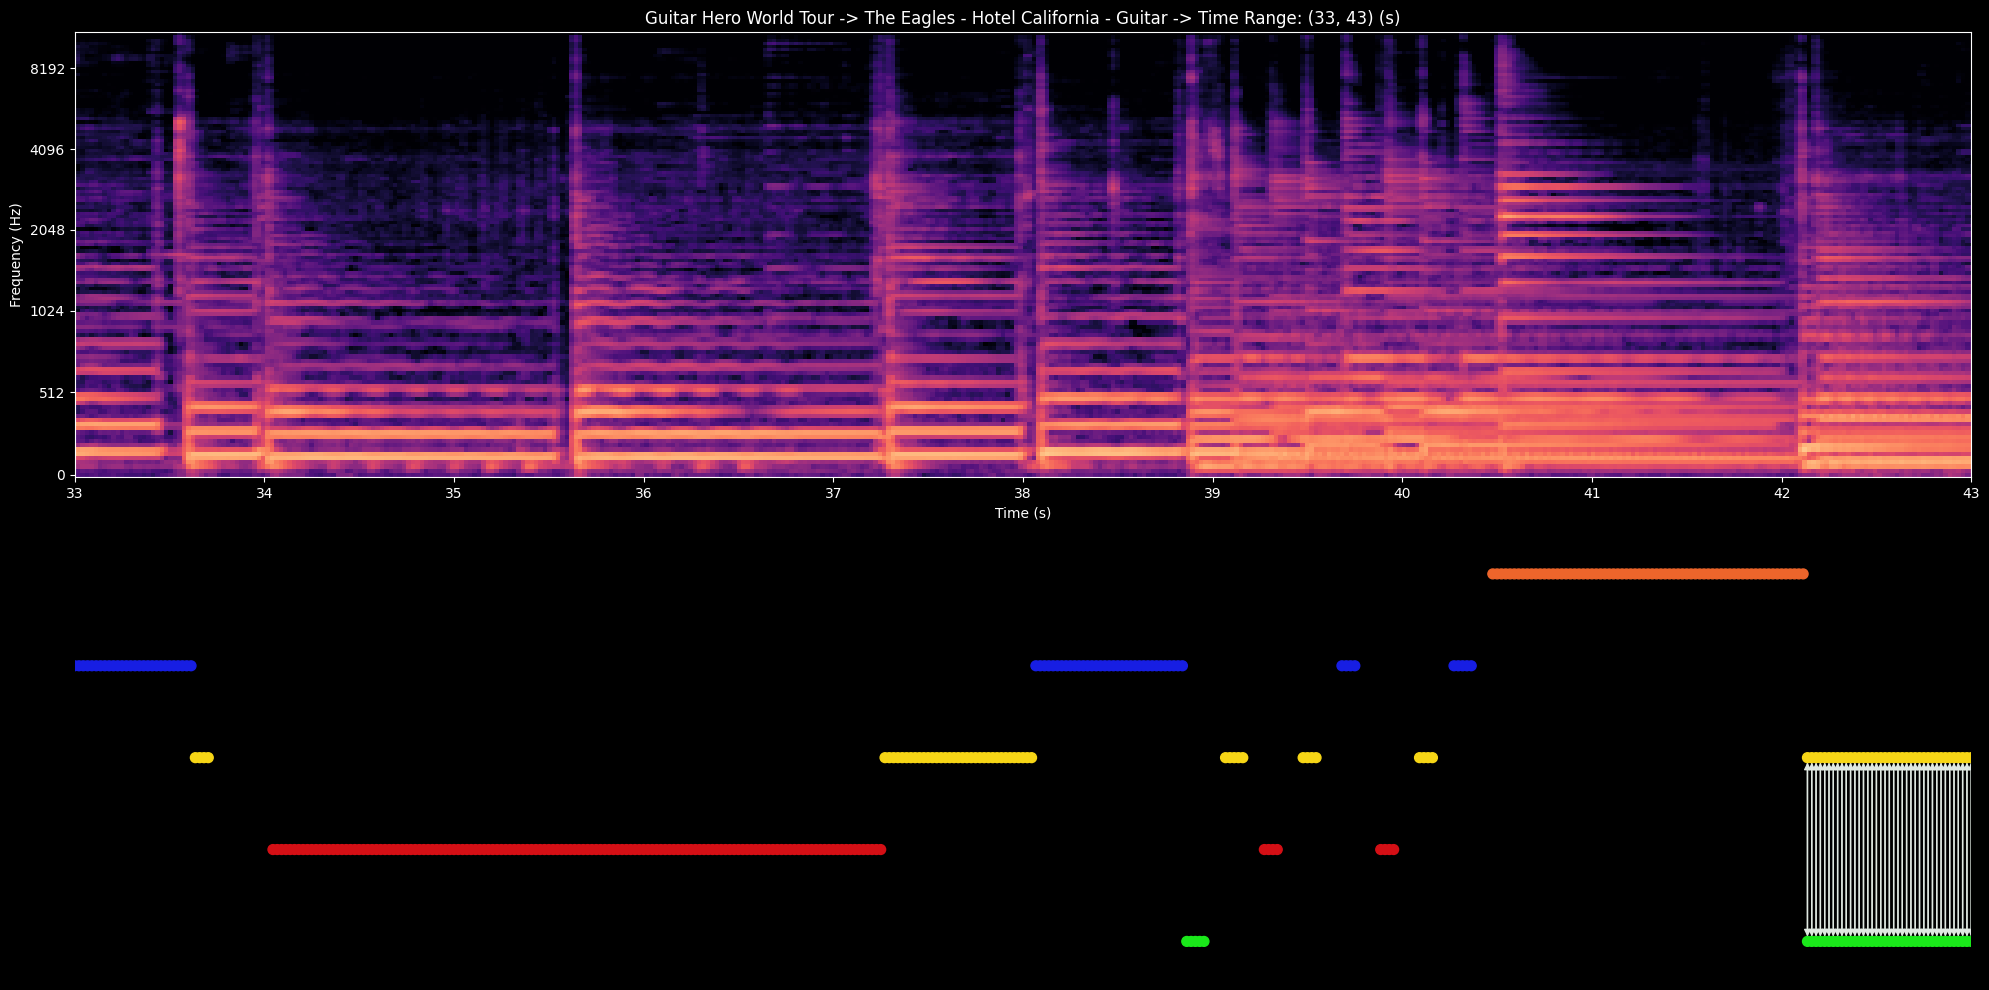

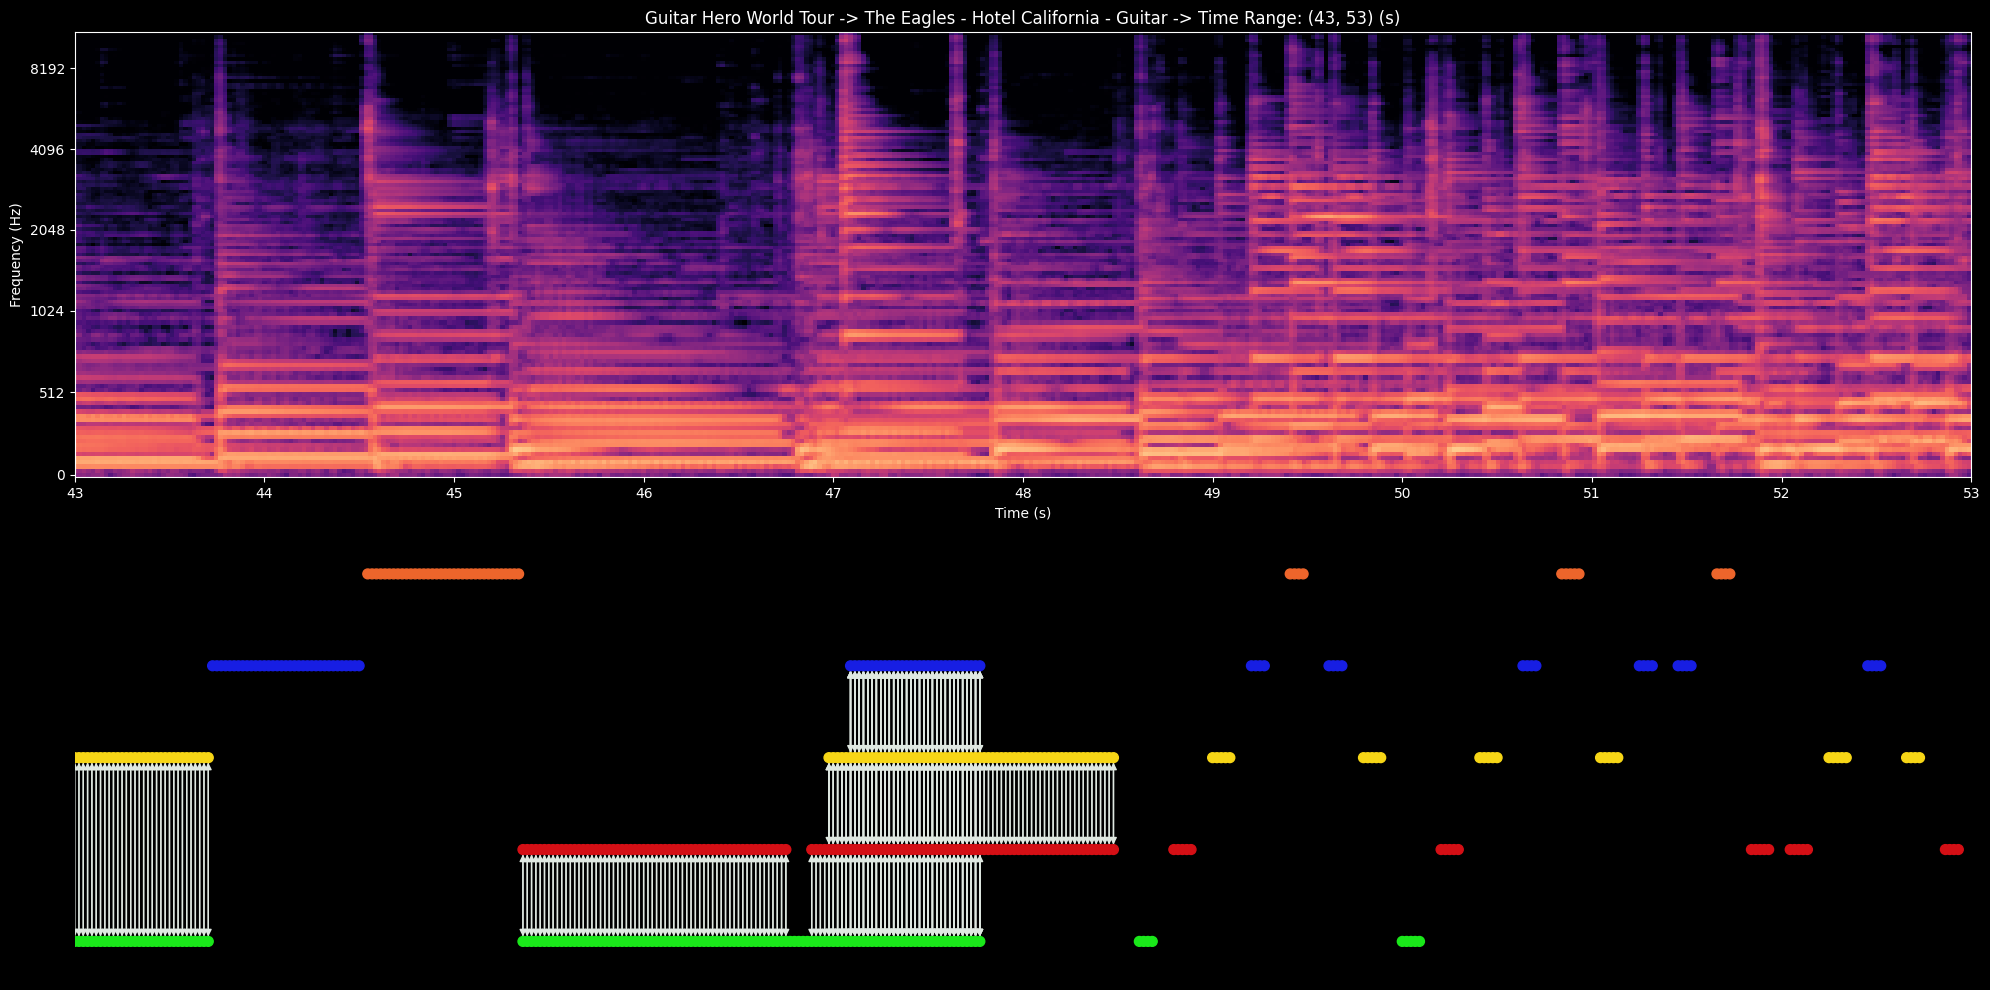

In [9]:
time_ranges = [(3, 13), (13, 23), (23, 33), (33, 43), (43, 53)]
for time_range in time_ranges:
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    axes[0] = plot_spec(
        melspec,
        title=f'Guitar Hero World Tour -> The Eagles - Hotel California - Guitar -> Time Range: {time_range} (s)',
        x_lim=time_range,
        fig_ax=(fig, axes[0]),
        show=False
    )
    axes[1] = plot_graph(
        graph,
        node_color,
        x_lim=time_range,
        fig_ax=(fig, axes[1]),
        show=False
    )

    plt.tight_layout()
    plt.show()

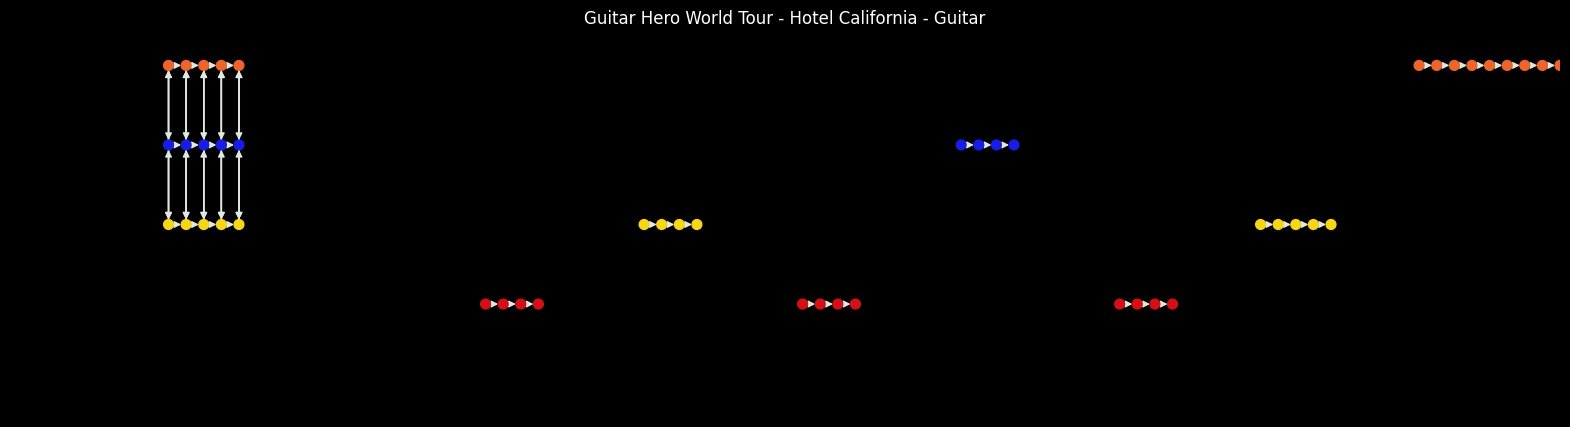

In [9]:
ax = plot_graph(graph, node_color, 'Guitar Hero World Tour - Hotel California - Guitar', x_lim=(3, 5))

In [330]:
samples = [note for note in instrument.notes if note.pitch in [96, 97, 98, 99, 100] and note.start >= 3.2 and note.end <= 53.0]
time_diff = []
for sample in samples:
    time_diff.append(sample.end - sample.start)

time_diff

[0.10075000000000012,
 0.10075000000000012,
 0.10075000000000012,
 0.10074999999999967,
 0.10075000000000012,
 0.10074999999999967,
 0.10074999999999967,
 0.10074999999999967,
 0.09907083333333322,
 0.8043208333333336,
 0.10449999999999982,
 0.10449999999999982,
 0.10449999999999982,
 0.10449999999999982,
 0.10037499999999966,
 0.10037499999999966,
 0.09870208333333252,
 0.10037500000000055,
 0.10050000000000026,
 0.10050000000000026,
 0.10050000000000026,
 0.10050000000000026,
 1.6053250000000006,
 1.6053250000000006,
 0.10030000000000072,
 0.10030000000000072,
 0.10030000000000072,
 0.10030000000000072,
 0.10029999999999895,
 0.10030000000000072,
 0.10029999999999895,
 0.10030000000000072,
 0.10012500000000024,
 0.10012500000000024,
 0.09845624999999991,
 0.10012500000000024,
 0.10012500000000024,
 0.09845624999999991,
 0.10112499999999969,
 0.10112499999999969,
 0.10112499999999969,
 0.10125000000000028,
 0.10125000000000028,
 0.10125000000000028,
 0.10125000000000028,
 1.6233062499